In [338]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from scripts.utils import sinkhorn, MMDLoss, RBF

def simple_mmd(X, Y):
    Z = torch.vstack([X, Y])
    L2_distances = torch.cdist(Z, Z) ** 2
    K = torch.exp(-0.5 * L2_distances)
    X_size = X.shape[0]
    XX = K[:X_size, :X_size].mean()
    XY = K[:X_size, X_size:].mean()
    YY = K[X_size:, X_size:].mean()
    return XX - 2 * XY + YY

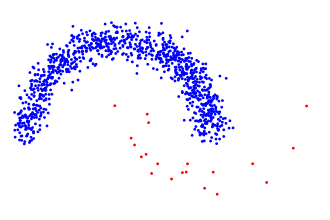

In [339]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = torch.cat(
        [
            torch.pi * torch.rand(n),
            torch.pi * torch.rand(n // 50) + torch.pi,
        ]
    )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label

torch.manual_seed(5)
samples, labels = two_moons(1000)

plt.figure(figsize=(4, 4))
plt.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig("images/two_moons.png", dpi=300)

In [340]:
nominal = samples[labels == 0]
failure = samples[labels == 1]
failure.shape

torch.Size([20, 2])

In [341]:
# Train single NSF with KL regularization
beta = 0.01
# flow_nsf_beta_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_failure = zuko.flows.NSF(features=2, context=5, hidden_features=(64, 64))
# nominal_optimizer = torch.optim.Adam(flow_nsf_beta_nominal.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(flow_nsf_beta_failure.parameters(), lr=1e-3, weight_decay=0.0)

pbar = tqdm(range(200))
for epoch in pbar:
    failure_optimizer.zero_grad()

    p_dist = flow_nsf_beta_failure(torch.ones(5))
    q_dist = flow_nsf_beta_failure(torch.zeros(5))
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((100,))
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    loss_failure = (
        -flow_nsf_beta_failure(torch.ones(5)).log_prob(failure).mean() + beta * kl_divergence
    )

    loss_failure += -flow_nsf_beta_failure(torch.zeros(5)).log_prob(nominal).mean()

    loss_failure.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}), {loss_failure.detach().item():.3f}"
    )

(199), -0.302: 100%|██████████| 200/200 [00:36<00:00,  5.51it/s]


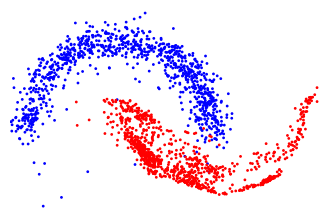

In [342]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
nominal_samples = flow_nsf_beta_failure(torch.zeros(5)).sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_failure(torch.ones(5)).sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)
samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
# plt.savefig('images/two_moons_nsf_context_beta.png', dpi=300)

In [343]:
# Train calibrated NSF
beta = 1.0
n_permutations = 2
permutation_size = int(0.5 * failure.shape[0])
flow_nsf_beta_calibrated_failure = zuko.flows.NSF(
    features=2, context=n_permutations, hidden_features=(64, 64)
)
failure_optimizer = torch.optim.Adam(
    flow_nsf_beta_calibrated_failure.transform.parameters(), lr=1e-3
)

mixture_label = torch.zeros(n_permutations, requires_grad=True)
mixture_label_optimizer = torch.optim.Adam([mixture_label], lr=1e-3)

# Create a set of permuted failure samples
permutation = torch.randperm(failure.shape[0])
failure_permutations = [permutation[:permutation_size], permutation[permutation_size:]]
# failure_permutations = []
# for i in range(n_permutations):
#     failure_permutations.append(torch.randperm(failure.shape[0])[:permutation_size])

pbar = tqdm(range(200))
for epoch in pbar:
    # Train the mixture label
    mixture_label_optimizer.zero_grad()
    mixture_label_loss = -flow_nsf_beta_calibrated_failure(mixture_label).log_prob(
        failure
    ).mean()
    mixture_label_loss.backward()
    mixture_label_optimizer.step()

    failure_optimizer.zero_grad()
    total_failure_loss = torch.tensor(0.0)

    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = 1.0
        total_failure_loss += (
            -flow_nsf_beta_calibrated_failure(label)
            .log_prob(failure[failure_permutations[i]])
            .mean()
            / n_permutations
        )

    # Add the loss for the optimized label
    total_failure_loss += -flow_nsf_beta_calibrated_failure(mixture_label).log_prob(
        failure
    ).mean()

    # Also try to reconstruct the nominal with a zero label
    label = torch.zeros(n_permutations)
    total_failure_loss += (
        -flow_nsf_beta_calibrated_failure(label).log_prob(nominal).mean()
        # / n_permutations
    )

    total_failure_loss.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {total_failure_loss:.3f}"
    )

(2) 6.758:   2%|▏         | 3/200 [00:00<00:32,  6.04it/s]

(199) -1.050: 100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


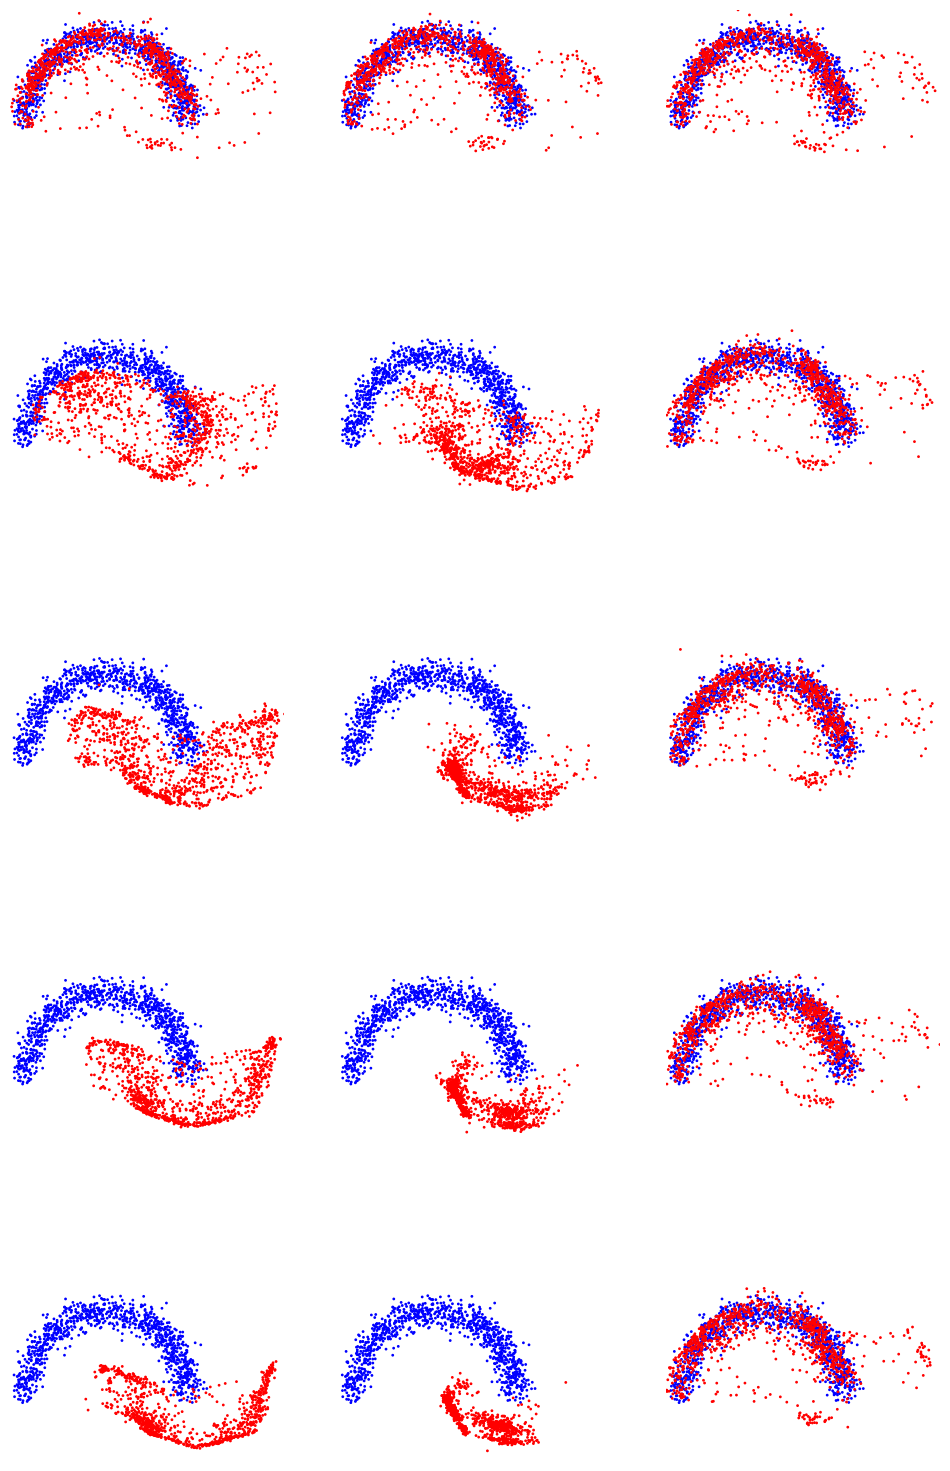

In [344]:
n_steps = 5
_, axs = plt.subplots(n_steps, 1 + n_permutations, figsize=(4 * (1 + n_permutations), 4 * n_steps))
for row, j in enumerate(torch.linspace(0, 1, n_steps)):
    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = j

        nominal_samples = nominal
        nominal_labels = torch.tensor([0.0]).expand(nominal_samples.shape[0])
        failure_samples = flow_nsf_beta_calibrated_failure(label).sample((nominal_samples.shape[0],))
        failure_labels = torch.tensor([1.0]).expand(nominal_samples.shape[0])

        samples = torch.cat((nominal_samples, failure_samples), axis=0)
        labels = torch.cat((nominal_labels, failure_labels), axis=0)
        axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
        # Turn off axis ticks
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])
        axs[row, i].axis("off")
        axs[row, i].set_ylim([-1.1, 1.1])
        axs[row, i].set_xlim([-1.7, 1.7])
        # Equal aspect
        axs[row, i].set_aspect("equal")
        # plt.savefig('images/two_moons_cnf_stacked.png', dpi=300)

    i = -1
    label = torch.zeros(n_permutations)
    nominal_samples = nominal
    nominal_labels = torch.tensor([0.0]).expand(nominal_samples.shape[0])
    failure_samples = flow_nsf_beta_calibrated_failure(label).sample((nominal_samples.shape[0],))
    failure_labels = torch.tensor([1.0]).expand(nominal_samples.shape[0])

    samples = torch.cat((nominal_samples, failure_samples), axis=0)
    labels = torch.cat((nominal_labels, failure_labels), axis=0)
    axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
    # Turn off axis ticks
    axs[row, i].set_xticks([])
    axs[row, i].set_yticks([])
    axs[row, i].axis("off")
    axs[row, i].set_ylim([-1.1, 1.1])
    axs[row, i].set_xlim([-1.7, 1.7])
    # Equal aspect
    axs[row, i].set_aspect("equal")

plt.savefig('images/two_moons_cnf_calibrated_range.png', dpi=300)

In [349]:
# Calibration step: can we optimize the label to maximize performance on the full set?
pbar = tqdm(range(100))
for epoch in pbar:
    mixture_label_optimizer.zero_grad()
    loss = -flow_nsf_beta_calibrated_failure(mixture_label).log_prob(failure).mean()
    loss.backward()
    mixture_label_optimizer.step()
    pbar.set_description(f"({epoch}) {loss.detach().item():.3f}")

print(mixture_label)

(99) -0.215: 100%|██████████| 100/100 [00:03<00:00, 31.08it/s]

tensor([0.1796, 0.2024], requires_grad=True)


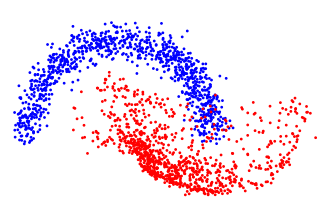

In [350]:
nominal_samples = nominal
nominal_labels = torch.tensor([0.0]).expand(nominal_samples.shape[0])
failure_samples = flow_nsf_beta_calibrated_failure(mixture_label).sample((nominal_samples.shape[0],))
failure_labels = torch.tensor([1.0]).expand(nominal_samples.shape[0])

samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)

_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig('images/two_moons_nsf_calibrated.png', dpi=300)

H(eval || p):
	Uncalibrated: 1.3700183629989624
	Calibrated: 1.1108382940292358


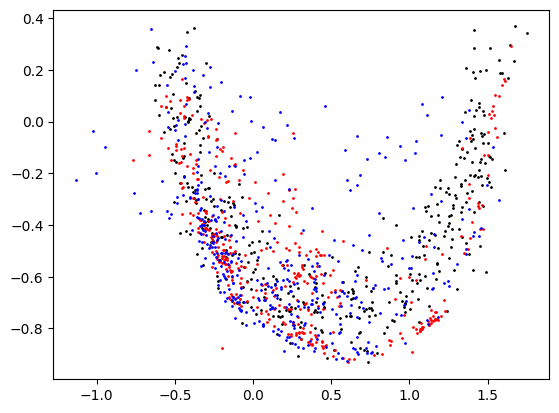

In [347]:
eval_samples, eval_labels = two_moons(20000)
eval_samples = eval_samples[eval_labels == 1]

uncalibrated_samples = flow_nsf_beta_failure(torch.ones(5)).sample((eval_samples.shape[0],))
calibrated_samples = flow_nsf_beta_calibrated_failure(mixture_label).sample((eval_samples.shape[0],))

plt.scatter(*eval_samples.T, s=1, c="k", label="True")
plt.scatter(*uncalibrated_samples.T, s=1, c="r", label="Uncalibrated")
plt.scatter(*calibrated_samples.T, s=1, c="b", label="Calibrated")

ce_eval_uncalibrated = -(
    flow_nsf_beta_failure(torch.ones(5)).log_prob(eval_samples)
).mean()
ce_eval_calibrated = -(
    flow_nsf_beta_calibrated_failure(mixture_label).log_prob(eval_samples)
).mean()
print("H(eval || p):")
print(f"\tUncalibrated: {ce_eval_uncalibrated}")
print(f"\tCalibrated: {ce_eval_calibrated}")

/tmp/ipykernel_3360974/5425843.py:5: UserWarning: linewidths is ignored by contourf
  plt.tricontourf(label_space[:, 0, 0], label_space[:, 0, 1], calibrated_logprobs, levels=50, linewidths=0.5, cmap="magma")


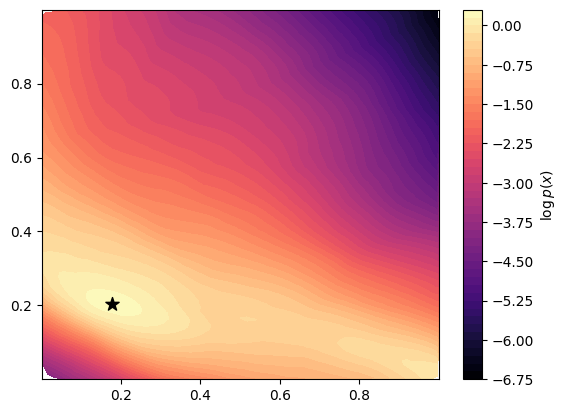

In [348]:
with torch.no_grad():
    label_space = torch.rand(10_000, 1, n_permutations)
    label_space[:, :, 2:] = mixture_label[2:]
    calibrated_logprobs = flow_nsf_beta_calibrated_failure(label_space).log_prob(failure).mean(dim=-1)
    plt.tricontourf(label_space[:, 0, 0], label_space[:, 0, 1], calibrated_logprobs, levels=50, linewidths=0.5, cmap="magma")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("$\log p(x)$")
    plt.scatter(*mixture_label[:2].detach().numpy().T, s=100, c="k", marker="*")
    plt.savefig("images/two_moons_calibration_landscape.png", dpi=300)